In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import h5py
import copy
import glob
from cartopy.io.shapereader import Reader

In [18]:
### Esta seccion requiere configuracion por el usuario

# genera la lista de años y el arreglo de meses
years = [2019,2020]          
meses = np.arange(1,13)

# informacion sobre el path de los archivos
readpath = 'f:\\jupyter\\oco3_mexico_city\\h5\\'
readformat = '.h5'

# use read_seedname si los nombres de la fuente tienen un formato establecido, de lo contrario use *
# NOTA: asegurese que el formato generado solo se repita en la seccion de fecha del archivo y no en otro identificador
# (e.g. orbita)
read_seedname = '*'

# yearformat: 0 si es dos digitos, 1 si es 4 digitos

yearformat = 1

# nombre en el archivo HDF de las variables de latitud (y), longitud (x), y de interes (z)
latname = '/latitude'
lonname = '/longitude'
zname = '/xco2'

### Fin de seccion que requiere configuracion por el usuario

In [19]:
# contadores inevitables 
cont = 0

In [20]:
archivos = []
for year in years:
    for mes in meses:
        if yearformat == 1:
            filedate = read_seedname + '%i%02i*' % (year,mes)
        else:
            filedate = read_seedname + '%i%02i*' % (year-2000,mes)
        datapath = readpath + filedate + readformat
        lista = glob.glob(datapath)
        lista.sort()
        #print(lista)
        for ele in lista:
            archivos.append(ele)
        
print(archivos)
# end of testing

['f:\\jupyter\\oco3_mexico_city\\h5\\04347a_fossil0036_20200208.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05078a_fossil0036_20200326.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05139a_fossil0036_20200330.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05322a_fossil0036_20200411.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05465a_fossil0036_20200420.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05587a_fossil0036_20200428.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05648a_fossil0036_20200502.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05709a_fossil0036_20200506.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05770a_volcano0002_20200510.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\05992a_fossil0036_20200524.h5', 'f:\\jupyter\\oco3_mexico_city\\h5\\06175a_volcano0002_20200605.h5']


In [21]:
for archivo in archivos:
    data = h5py.File(archivo, 'r')
    lat = np.expand_dims(data[latname],axis=1)
    lon = np.expand_dims(data[lonname],axis=1)
    zvar = np.expand_dims(data[zname],axis=1)
    # concatena los 4 vectores Nx1 en una matriz temporal Nx4
    mat=np.concatenate((lat,lon,zvar),axis=1)
    if cont == 0:
        # copia la matriz temporal en una permanente
        # esto solo se debe usar si no existe ya la matriz permanente
        datos=copy.copy(mat)
            
    else:
        # concatena los datos de la matriz temporal en la permanente
        # esto solo se debe usar si ya existe la matriz permanente
        datos=np.concatenate((mat,datos),axis=0)
                    
    cont = cont + 1
    data.close()
print(datos.shape)

(5363, 3)


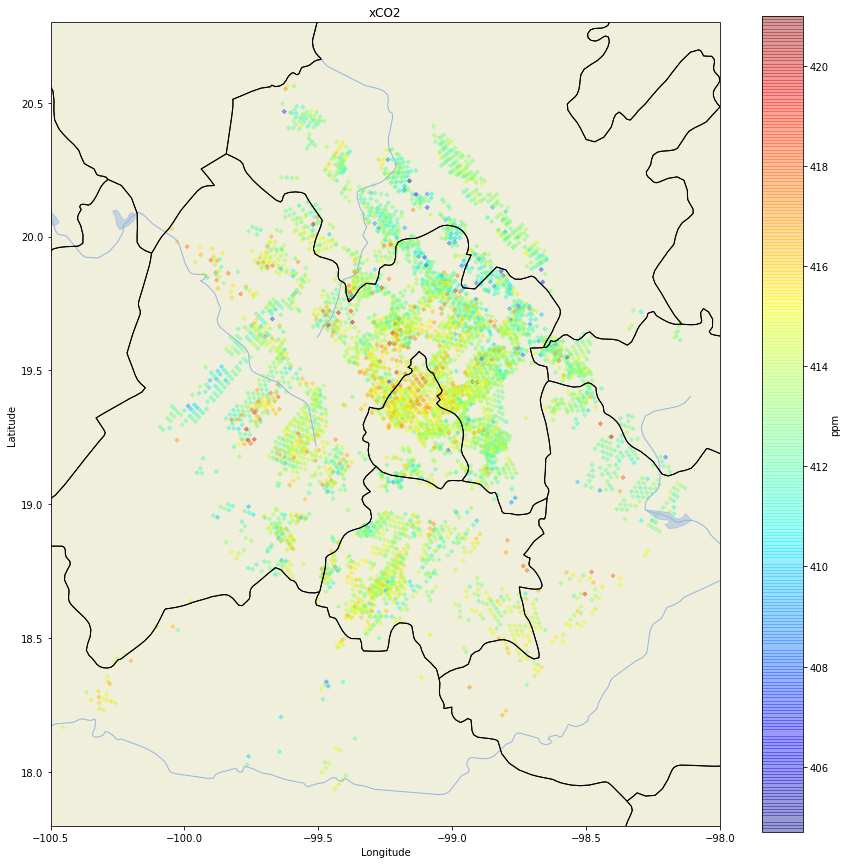

In [37]:
plt.figure(figsize=(15,15))

# Creates the map
mxmap = plt.axes(projection=ccrs.PlateCarree())

mxmap.add_feature(cfeature.LAND)
mxmap.add_feature(cfeature.OCEAN)
mxmap.add_feature(cfeature.COASTLINE)
mxmap.add_feature(cfeature.BORDERS, linestyle=':')
mxmap.add_feature(cfeature.LAKES, alpha=0.5)
mxmap.add_feature(cfeature.RIVERS)
mxmap.add_feature(cfeature.STATES.with_scale('10m'))
mxmap.set_extent((-100.5,-98,17.8,20.8))
mxmap.xaxis.set_visible(True)
mxmap.yaxis.set_visible(True)

plt.scatter(datos[:,1], datos[:,0], alpha=0.4, 
            s=8,c=datos[:,2], marker = 'D', 
            cmap=plt.get_cmap("jet"), 
            transform=ccrs.PlateCarree())
plt.title("xCO2")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar= plt.colorbar()
cbar.set_label("ppm", labelpad=+1)
plt.savefig('target_dist.png')
plt.show()